# How to use polygons or lines as exposure


## Introduction

Exposure in CLIMADA are usually represented as individual points or a raster of points.
See [Exposures](climada_entity_Exposures.ipynb) tutorial to learn how to fill and use exposures.
Polygones or lines can be useful to represent specific exposed assets like roads, buildings or ecosystems. In this tutorial we first show how to retrieve exposure data under the form of polygons or lines by querying
the [OpenStreetMap database](https://www.openstreetmap.org/). In a second time, we showcase how to run the impact calculation chain with polygons or lines exposure data.

## How to get lines or polygons exposure data from OpenStreetMap
[OpenStreetMap data](https://www.openstreetmap.org/) is a freely-accessible and valuable data source which can provide information on the locations of a variety of assets in space such as roads, hospitals, or forests. Such data can then be used within the risk modelling chain of CLIMADA as exposures. 
Within the CLIMADA plateform, there are several ways to obtain exposure data under the
form of polygons or lines:
1. Using the `osm_flex` module directly available from the CLIMADA core environment
2. Using the `OSMApiQuery` methods from the `Exposures.osm_dataloader` module available in CLIMADA petals

### OSM-flex
Here we illustrate how to obtain exposure data as lines and polygons using the `osm-flex`
module. `osm-flex` is a python package which allows to flexibly extract data from OpenStreetMap.
See https://osm-flex.readthedocs.io/en/latest/?badge=latest and the associated publication 
for more information: *Mühlhofer, Kropf, Riedel, Bresch and Koks: OpenStreetMap for Multi-Faceted Climate Risk Assessments. Environ. Res. Commun. **6** 015005 doi: [10.1088/2515-7620/ad15ab](https://iopscience.iop.org/article/10.1088/2515-7620/ad15ab)*  
We first show how to obtain road network exposure as lines for the country
of Honduras by indirectly querying the OpenStreetMap data API via the `osm-flex` module.
As a second example we illustrate how to obtain forest exposure as polygons.

In [1]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
import os

import osm_flex
import osm_flex.download
import osm_flex.extract
import osm_flex.clip
import osm_flex.simplify

from climada import CONFIG

osm_flex.enable_logs()

/Users/lseverino/miniforge3/envs/climada_osm/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


**Download**  a raw osm.pbf file ("data dump") for Honduras from geofabrik.de 

In [2]:
# (checks if file honduras-latest.osm.pbf already exists)
# file is stored as defined in osm_flex.config.OSM_DATA_DIR unless specified otherwise
iso3 = "HND"
path_hnd_dump = osm_flex.download.get_country_geofabrik(iso3)

INFO:osm_flex.download:Download file: /Users/lseverino/osm/osm_bpf/honduras-latest.osm.pbf


**Extracting pre-written query classes from the data dump**

Extracting critical infrastructure with pre-written queries:
For critical infrastructure, a set of wrappers exist that parse all data belonging to this sector. 

In [3]:
# check available critical infrastructure types:
osm_flex.config.DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [4]:
# lets extract all roads from the Honduras file, via the wrapper
gdf_roads_hnd = osm_flex.extract.extract_cis(path_hnd_dump, "road")

INFO:osm_flex.extract:query is finished, lets start the loop
extract points: 0it [00:00, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 0it [00:06, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract lines: 100%|██████████| 132099/132099 [00:06<00:00, 21840.90it/s]


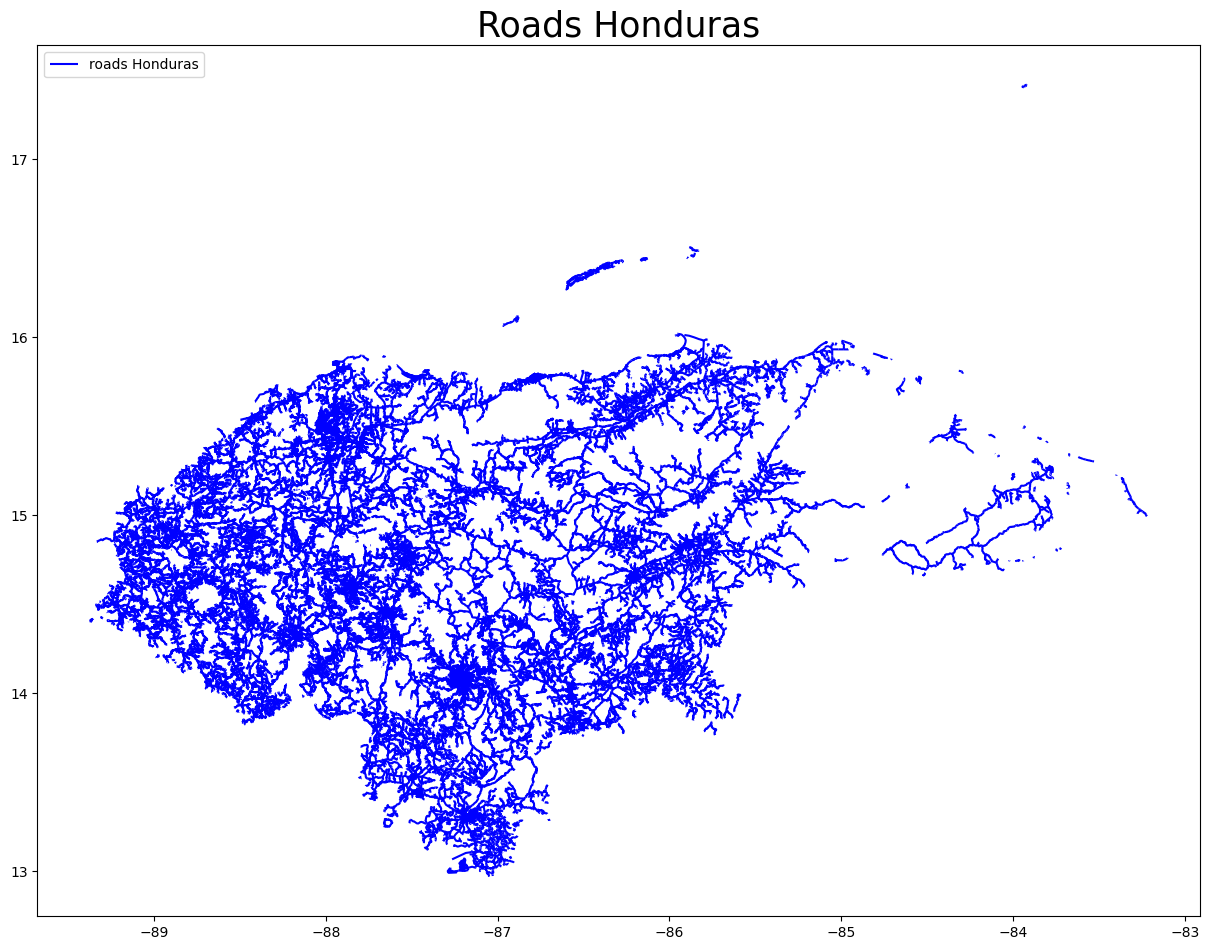

In [5]:
# plot results
ax = gdf_roads_hnd.plot(
    figsize=(15, 15),
    alpha=1,
    markersize=5,
    color="blue",
    edgecolor="blue",
    label="roads Honduras",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc="upper left")
ax.set_title("Roads Honduras", fontsize=25)
plt.show()

**Extracting any custom-made query from the data dump**

Any other tags that are available on openstreetmap can also be queried with the `extract()` method.
Two variables have to be specified: `osm_keys`, a list with all the columns to report in the gdf, and `osm_query`, a string of key-value constraints to apply during the search.

In [6]:
# Forests (multipolygons) in Honduras
osm_keys = ["landuse"]
osm_query = "landuse='forest'"
gdf_forest = osm_flex.extract.extract(
    path_hnd_dump, "multipolygons", osm_keys, osm_query
)

INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|██████████| 750/750 [00:06<00:00, 121.89it/s]


/var/folders/y5/t1z41tgj7dv50sm2_29dn8740000gp/T/ipykernel_20522/4202721382.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


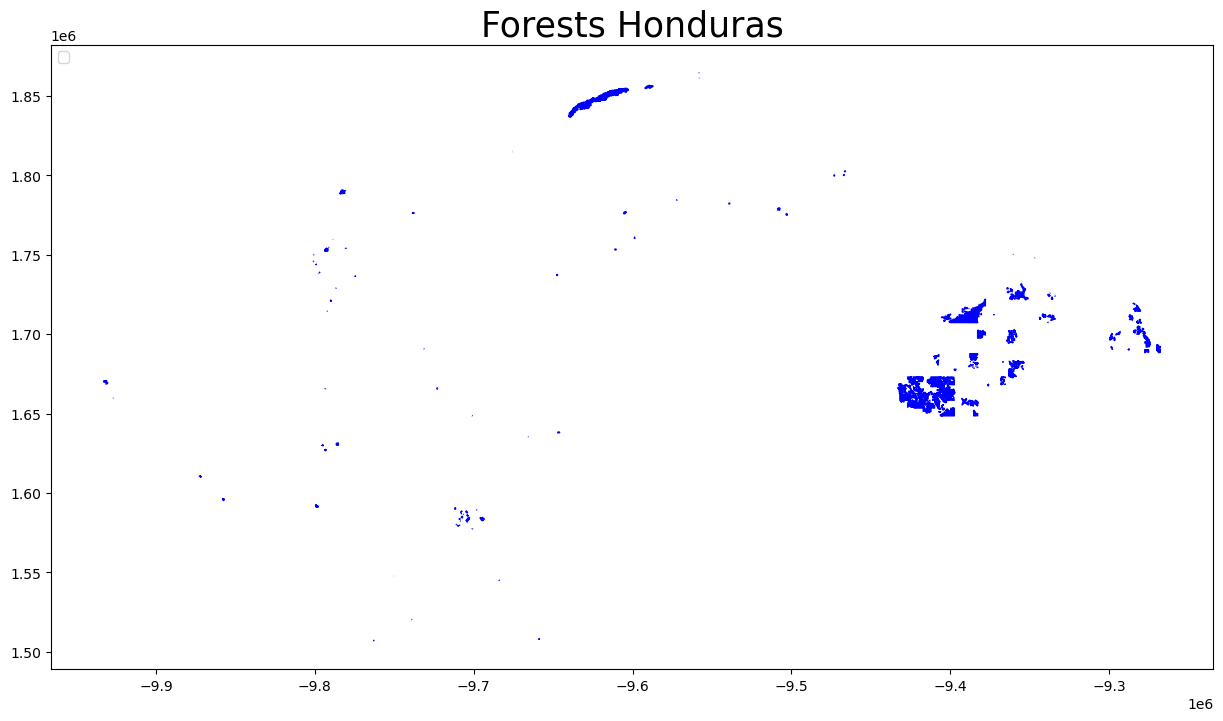

In [7]:
# Plot results
ax = gdf_forest.to_crs(epsg=3857).plot(
    figsize=(15, 15),
    alpha=1,
    markersize=5,
    color="blue",
    edgecolor="blue",
    label="forests HND",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc="upper left")
ax.set_title("Forests Honduras", fontsize=25)
plt.show()

### OSMApiQuery
To download and process data using `OSMApiQuery` methods from the `Exposures.osm_dataloader` module 
available in CLIMADA petals please refer to the online documentation at https://climada-petals.readthedocs.io/en/stable/tutorial/climada_exposures_openstreetmap.html.

## How to compute impacts using polygons or lines as exposure in CLIMADA
The approach provides an all-in-one method for impact calculation: `calc_geom_impact`
It features three sub-steps, for which the current util module `lines_polys_handler` also provides separate functions:

1. Disaggregation of line and polygon data into point exposure:
    * Interpolate geometries to points to fit in an `Exposure` instance; 
    * Disaggregate the respective geometry values to the point values
2. Perform the impact calculation in CLIMADA with the point exposure
3. Aggregate the calculated point `Impact` back to an impact instance for the initial polygons or lines  

### Quick example

Get example polygons (provinces), lines (rails), points exposure for the Netherlands, and create one single Exposures. Get demo winter storm hazard and a corresponding impact function.

In [ ]:
from climada.util.api_client import Client
import climada.util.lines_polys_handler as u_lp
from climada.entity.impact_funcs import ImpactFuncSet
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity import Exposures

HAZ = Client().get_hazard("storm_europe", name="test_haz_WS_nl", status="test_dataset")

EXP_POLY = Client().get_exposures(
    "base", name="test_polygon_exp", status="test_dataset"
)
EXP_LINE = Client().get_exposures("base", name="test_line_exp", status="test_dataset")
EXP_POINT = Client().get_exposures("base", name="test_point_exp", status="test_dataset")

EXP_MIX = Exposures.concat([EXP_POLY, EXP_LINE, EXP_POINT])

IMPF = ImpfStormEurope.from_welker()
IMPF_SET = ImpactFuncSet([IMPF])

Compute the impact in one line.

In [2]:
# disaggregate in the same CRS as the exposures are defined (here degrees), resolution 1degree
# divide values on points
# aggregate by summing

impact = u_lp.calc_geom_impact(
    exp=EXP_MIX,
    impf_set=IMPF_SET,
    haz=HAZ,
    res=0.2,
    to_meters=False,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
    agg_met=u_lp.AggMethod.SUM,
)

2022-06-24 13:16:15,277 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-06-24 13:16:15,284 - climada.entity.exposures.base - INFO - Matching 183 exposures with 9944 centroids.
2022-06-24 13:16:15,285 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:16:15,295 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-06-24 13:16:15,296 - climada.engine.impact - INFO - Calculating damage for 182 assets (>0) and 2 events.


/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:931: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  line_lengths = gdf_lines.length


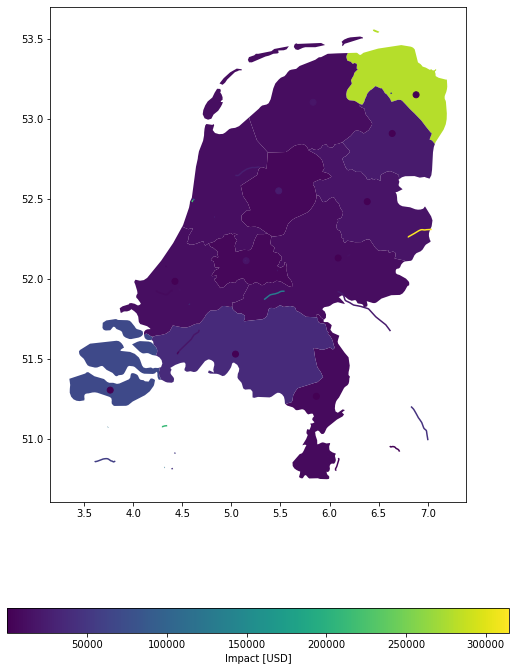

In [3]:
u_lp.plot_eai_exp_geom(impact);

In [4]:
# disaggregate in meters
# same value for each point, fixed to 1 (allows to get percentages of affected surface/distance)
# aggregate by summing

impact = u_lp.calc_geom_impact(
    exp=EXP_MIX,
    impf_set=IMPF_SET,
    haz=HAZ,
    res=1000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=1.0,
    agg_met=u_lp.AggMethod.SUM,
);

2022-06-24 13:16:17,387 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-06-24 13:16:18,069 - climada.entity.exposures.base - INFO - Matching 37357 exposures with 9944 centroids.
2022-06-24 13:16:18,073 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:16:18,114 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-06-24 13:16:18,117 - climada.engine.impact - INFO - Calculating damage for 37357 assets (>0) and 2 events.


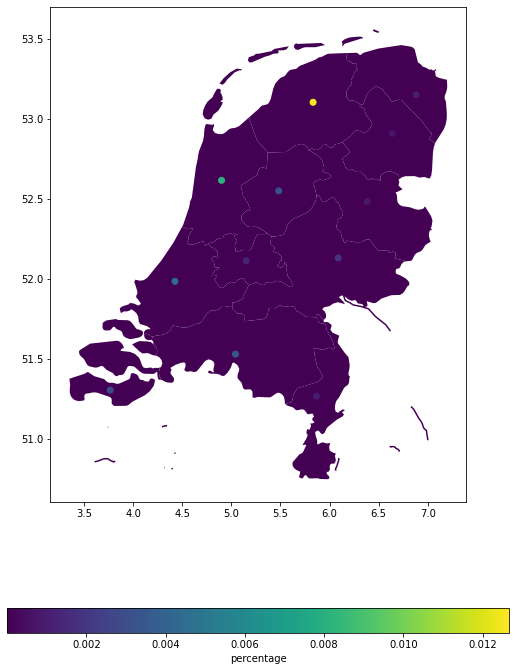

In [5]:
import matplotlib.pyplot as plt

ax = u_lp.plot_eai_exp_geom(
    impact, legend_kwds={"label": "percentage", "orientation": "horizontal"}
)

### Polygons

Polygons or shapes are a common geographical representation of countries, states etc. as for example in NaturalEarth.
Map data, as for example buildings, etc. obtained from openstreetmap (see tutorial [here](https://github.com/CLIMADA-project/climada_petals/blob/feature/osm_loaders/doc/tutorial/climada_exposures_openstreetmap.ipynb)), also frequently come as (multi-)polygons.
Here we want to show you how to deal with exposure information as polygons.

#### Load data

Lets assume we have the following data given. The polygons of the admin-1 regions of the Netherlands and an exposure value each, which we gather in a geodataframe. We want to know the Impact of Lothar on each admin-1 region.

In this tutorial, we shall see how to compute impacts for exposures defined on shapely geometries (polygons and/or lines). The basic principle is to disaggregate the geometries to a raster of points, compute the impact per points, and then re-aggregate. To do so, several methods are available. Here is a brief overview.

In [6]:
# Imports
import geopandas as gpd
import pandas as pd
from pathlib import Path

from climada.entity import Exposures
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet
from climada.engine import ImpactCalc
from climada.hazard.storm_europe import StormEurope
import climada.util.lines_polys_handler as u_lp
from climada.util.constants import DEMO_DIR, WS_DEMO_NC

In [7]:
def gdf_poly():
    from cartopy.io import shapereader
    from climada_petals.entity.exposures.black_marble import country_iso_geom

    # open the file containing the Netherlands admin-1 polygons
    shp_file = shapereader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
    shp_file = shapereader.Reader(shp_file)

    # extract the NL polygons
    prov_names = {
        "Netherlands": [
            "Groningen",
            "Drenthe",
            "Overijssel",
            "Gelderland",
            "Limburg",
            "Zeeland",
            "Noord-Brabant",
            "Zuid-Holland",
            "Noord-Holland",
            "Friesland",
            "Flevoland",
            "Utrecht",
        ]
    }
    polygon_Netherlands, polygons_prov_NL = country_iso_geom(prov_names, shp_file)
    prov_geom_NL = {
        prov: geom
        for prov, geom in zip(
            list(prov_names.values())[0], list(polygons_prov_NL.values())[0]
        )
    }

    # assign a value to each admin-1 area (assumption 100'000 USD per inhabitant)
    population_prov_NL = {
        "Drenthe": 493449,
        "Flevoland": 422202,
        "Friesland": 649988,
        "Gelderland": 2084478,
        "Groningen": 585881,
        "Limburg": 1118223,
        "Noord-Brabant": 2562566,
        "Noord-Holland": 2877909,
        "Overijssel": 1162215,
        "Zuid-Holland": 3705625,
        "Utrecht": 1353596,
        "Zeeland": 383689,
    }
    value_prov_NL = {
        n: 100000 * population_prov_NL[n] for n in population_prov_NL.keys()
    }

    # combine into GeoDataFrame and add a coordinate reference system to it:
    df1 = pd.DataFrame.from_dict(
        population_prov_NL, orient="index", columns=["population"]
    ).join(pd.DataFrame.from_dict(value_prov_NL, orient="index", columns=["value"]))
    df1["geometry"] = [prov_geom_NL[prov] for prov in df1.index]
    gdf_polys = gpd.GeoDataFrame(df1)
    gdf_polys = gdf_polys.set_crs(epsg=4326)
    return gdf_polys

In [8]:
exp_nl_poly = Exposures(gdf_poly())
exp_nl_poly.gdf["impf_WS"] = 1
exp_nl_poly.gdf.head()

,population,value,geometry,impf_WS
Drenthe,493449,49344900000,"POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...",1
Flevoland,422202,42220200000,"POLYGON ((5.74046 52.83874, 5.75012 52.83507, ...",1
Friesland,649988,64998800000,"MULTIPOLYGON (((5.17977 53.00899, 5.27947 53.0...",1
Gelderland,2084478,208447800000,"POLYGON ((6.77158 52.10879, 6.76587 52.10840, ...",1
Groningen,585881,58588100000,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...",1


<AxesSubplot:>

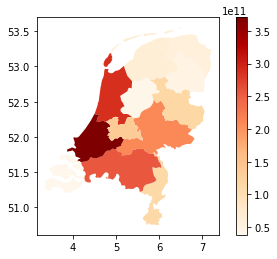

In [9]:
# take a look
exp_nl_poly.gdf.plot("value", legend=True, cmap="OrRd")

In [10]:
# define hazard
storms = StormEurope.from_footprints(WS_DEMO_NC)
# define impact function
impf = ImpfStormEurope.from_welker()
impf_set = ImpactFuncSet([impf])

2022-06-24 13:16:20,039 - climada.hazard.storm_europe - INFO - Constructing centroids from /Users/ckropf/climada/demo/data/fp_lothar_crop-test.nc
2022-06-24 13:16:20,124 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/ckropf/Documents/Climada/climada_python/climada/hazard/centroids/centr.py:822: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2022-06-24 13:16:22,004 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.


#### Compute polygon impacts - all in one

**All in one:** The main method `calc_geom_impact` provides several disaggregation keywords, specifiying

- the target resolution (`res`), 
- the method on how to distribute the values of the original geometries onto the newly generated interpolated points (`disagg_met`)
- the source (and number) of the value to be distributed (`disagg_val`). 
- the aggregation method (`agg_met`)

`disagg_met` can be either fixed (`FIX`), replicating the original shape's value onto all points, or divided evenly (`DIV`), in which case the value is divided equally onto all new points.
`disagg_val` can either be taken directly from the exposure gdf's value column (`None`) or be indicated here explicitly (`float`). Resolution can be given in the gdf's original (mostly degrees lat/lon) format, or in metres. `agg_met` can currently be only (`SUM`) were the value is summed over all points in the geometry.

*Polygons can also be disaggregated on a given fixed grid, see example below*

**Example 1**: Target resolution in degrees lat/lon, equal (average) distribution of values from exposure gdf among points.

In [11]:
imp_deg = u_lp.calc_geom_impact(
    exp=exp_nl_poly,
    impf_set=impf_set,
    haz=storms,
    res=0.005,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
    agg_met=u_lp.AggMethod.SUM,
)

2022-06-24 13:16:30,535 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-06-24 13:16:33,946 - climada.entity.exposures.base - INFO - Matching 195323 exposures with 9944 centroids.
2022-06-24 13:16:33,950 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:16:34,140 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-06-24 13:16:34,144 - climada.engine.impact - INFO - Calculating damage for 195323 assets (>0) and 2 events.


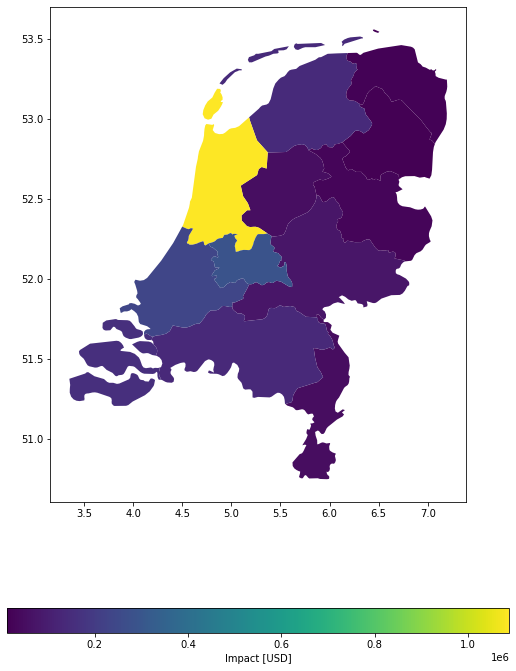

In [12]:
u_lp.plot_eai_exp_geom(imp_deg);

**Example 2**: Target resolution in metres, equal (divide) distribution of values from exposure gdf among points.

In [13]:
imp_m = u_lp.calc_geom_impact(
    exp=exp_nl_poly,
    impf_set=impf_set,
    haz=storms,
    res=500,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
    agg_met=u_lp.AggMethod.SUM,
)

2022-06-24 13:16:41,366 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-06-24 13:16:44,164 - climada.entity.exposures.base - INFO - Matching 148369 exposures with 9944 centroids.
2022-06-24 13:16:44,168 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:16:44,387 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-06-24 13:16:44,390 - climada.engine.impact - INFO - Calculating damage for 148369 assets (>0) and 2 events.


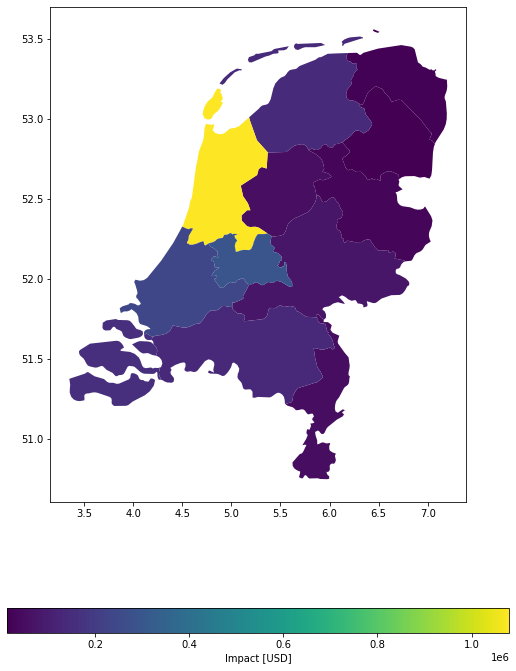

In [14]:
u_lp.plot_eai_exp_geom(imp_m);

For this specific case, both disaggregation methods provide a relatively similar result, given the chosen numbers:

In [15]:
(imp_deg.eai_exp - imp_m.eai_exp) / imp_deg.eai_exp

array([ 0.00614586, -0.01079377,  0.00021355,  0.00140608,  0.0038771 ,
       -0.0066888 , -0.00171755,  0.00741871, -0.00107029,  0.00424221,
       -0.01838225,  0.01811858])

**Example 3**: Target predefined grid, equal (divide) distribution of values from exposure gdf among points.

In [16]:
# regular grid from exposures bounds
import climada.util.coordinates as u_coord

res = 0.1
(_, _, xmax, ymax) = exp_nl_poly.gdf.geometry.bounds.max()
(xmin, ymin, _, _) = exp_nl_poly.gdf.geometry.bounds.min()
bounds = (xmin, ymin, xmax, ymax)
height, width, trafo = u_coord.pts_to_raster_meta(bounds, (res, res))
x_grid, y_grid = u_coord.raster_to_meshgrid(trafo, width, height)

In [17]:
imp_g = u_lp.calc_grid_impact(
    exp=exp_nl_poly,
    impf_set=impf_set,
    haz=storms,
    grid=(x_grid, y_grid),
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
    agg_met=u_lp.AggMethod.SUM,
)

2022-06-24 13:16:45,086 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-06-24 13:16:45,100 - climada.entity.exposures.base - INFO - Matching 486 exposures with 9944 centroids.
2022-06-24 13:16:45,102 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:16:45,110 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-06-24 13:16:45,111 - climada.engine.impact - INFO - Calculating damage for 486 assets (>0) and 2 events.


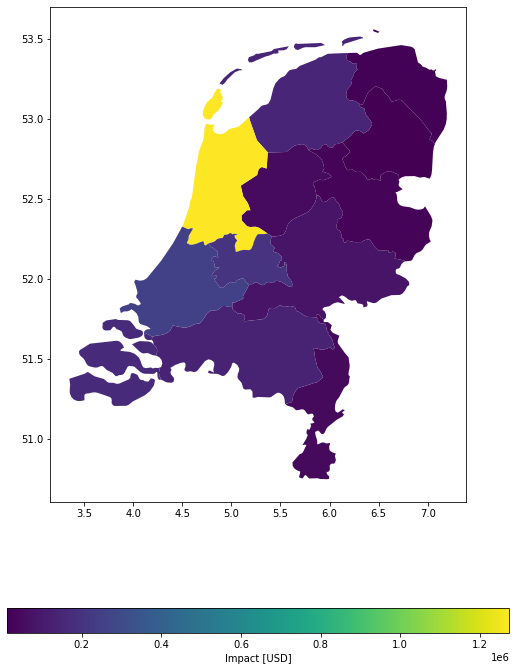

In [18]:
u_lp.plot_eai_exp_geom(imp_g);

#### Compute polygon impacts - step by step

**Step 1:** Disaggregate polygon exposures to points. It is useful to do this separately, when the discretized exposure is used several times, for example, to compute with different hazards.

Several disaggregation methods can be used as shown below:

In [19]:
# Disaggregate exposure to 10'000 metre grid, each point gets average value within polygon.
exp_pnt = u_lp.exp_geom_to_pnt(
    exp_nl_poly,
    res=10000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
)
exp_pnt.gdf.head()

2022-06-24 13:16:45,445 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population         value  \
Drenthe 0      493449  2.056038e+09   
        1      493449  2.056038e+09   
        2      493449  2.056038e+09   
        3      493449  2.056038e+09   
        4      493449  2.056038e+09   

                                               geometry_orig  impf_WS  \
Drenthe 0  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        1  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        2  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        3  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        4  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   

                           geometry   latitude  longitude  
Drenthe 0  POINT (6.21931 52.75939)  52.759394   6.219308  
        1  POINT (6.30914 52.75939)  52.759394   6.309139  
        2  POINT (6.39897 52.75939)  52.759394   6.398971  
        3  POINT (6.48880 52.75939)  52.759394   6.488802  
        4  POINT (6.57863 52.75939)  52.759394   6.578634

In [20]:
# Disaggregate exposure to 0.1° grid, no value disaggregation specified --> replicate initial value
exp_pnt2 = u_lp.exp_geom_to_pnt(
    exp_nl_poly,
    res=0.1,
    to_meters=False,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=None,
)
exp_pnt2.gdf.head()

2022-06-24 13:16:45,516 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population        value  \
Drenthe 0      493449  49344900000   
        1      493449  49344900000   
        2      493449  49344900000   
        3      493449  49344900000   
        4      493449  49344900000   

                                               geometry_orig  impf_WS  \
Drenthe 0  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        1  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        2  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        3  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        4  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   

                           geometry   latitude  longitude  
Drenthe 0  POINT (6.22948 52.71147)  52.711466   6.229476  
        1  POINT (6.32948 52.71147)  52.711466   6.329476  
        2  POINT (6.42948 52.71147)  52.711466   6.429476  
        3  POINT (6.52948 52.71147)  52.711466   6.529476  
        4  POINT (6.62948 52.71147)  52.711466   6.629476

In [21]:
# Disaggregate exposure to 1'000 metre grid, each point gets value corresponding to
# its representative area (1'000^2).
exp_pnt3 = u_lp.exp_geom_to_pnt(
    exp_nl_poly,
    res=1000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=10e6,
)
exp_pnt3.gdf.head()

2022-06-24 13:16:47,258 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population       value  \
Drenthe 0      493449  10000000.0   
        1      493449  10000000.0   
        2      493449  10000000.0   
        3      493449  10000000.0   
        4      493449  10000000.0   

                                               geometry_orig  impf_WS  \
Drenthe 0  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        1  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        2  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        3  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   
        4  POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...        1   

                           geometry   latitude  longitude  
Drenthe 0  POINT (6.38100 52.62624)  52.626236   6.381005  
        1  POINT (6.38999 52.62624)  52.626236   6.389988  
        2  POINT (6.39897 52.62624)  52.626236   6.398971  
        3  POINT (6.40795 52.62624)  52.626236   6.407954  
        4  POINT (6.41694 52.62624)  52.626236   6.416937

In [22]:
# Disaggregate exposure to 1'000 metre grid, each point gets value corresponding to 1
# After dissagregation, each point has a value equal to the percentage of area of the polygon
exp_pnt4 = u_lp.exp_geom_to_pnt(
    exp_nl_poly,
    res=1000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=1,
)
exp_pnt4.gdf.tail()

2022-06-24 13:16:49,929 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population     value  \
Zeeland 1897      383689  0.000526   
        1898      383689  0.000526   
        1899      383689  0.000526   
        1900      383689  0.000526   
        1901      383689  0.000526   

                                                  geometry_orig  impf_WS  \
Zeeland 1897  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        1898  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        1899  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        1900  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        1901  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   

                              geometry   latitude  longitude  
Zeeland 1897  POINT (3.92434 51.73813)  51.738126   3.924336  
        1898  POINT (3.93332 51.73813)  51.738126   3.933320  
        1899  POINT (3.94230 51.73813)  51.738126   3.942303  
        1900  POINT (3.95129 51.73813)  51.738126   3.951286  
        1901  POINT (3.96027 51.73813)  51.738126   3.960269

In [23]:
# disaggregate on pre-defined grid
# regular grid from exposures bounds
import climada.util.coordinates as u_coord

res = 0.1
(_, _, xmax, ymax) = exp_nl_poly.gdf.geometry.bounds.max()
(xmin, ymin, _, _) = exp_nl_poly.gdf.geometry.bounds.min()
bounds = (xmin, ymin, xmax, ymax)
height, width, trafo = u_coord.pts_to_raster_meta(bounds, (res, res))
x_grid, y_grid = u_coord.raster_to_meshgrid(trafo, width, height)
exp_pnt5 = u_lp.exp_geom_to_grid(
    exp_nl_poly, grid=(x_grid, y_grid), disagg_met=u_lp.DisaggMethod.DIV, disagg_val=1
)
exp_pnt5.gdf.tail()

2022-06-24 13:16:50,765 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


population     value  \
Zeeland 17      383689  0.045455   
        18      383689  0.045455   
        19      383689  0.045455   
        20      383689  0.045455   
        21      383689  0.045455   

                                                geometry_orig  impf_WS  \
Zeeland 17  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        18  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        19  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        20  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   
        21  MULTIPOLYGON (((3.45388 51.23563, 3.42194 51.2...        1   

                            geometry  latitude  longitude  
Zeeland 17  POINT (3.84941 51.54755)  51.54755   3.849415  
        18  POINT (4.14941 51.54755)  51.54755   4.149415  
        19  POINT (3.94941 51.64755)  51.64755   3.949415  
        20  POINT (4.04941 51.64755)  51.64755   4.049415  
        21  POINT (4.14941 51.64755)  51.64755   4.149415

**Step 2:** Calculate point impacts & re-aggregate them afterwards

In [24]:
# Point-impact
imp_pnt = ImpactCalc(exp_pnt3, impf_set, hazard=storms).impact(save_mat=True)

# Aggregated impact (Note that you need to pass the gdf and not the exposures)
imp_geom = u_lp.impact_pnt_agg(imp_pnt, exp_pnt3.gdf, agg_met=u_lp.AggMethod.SUM)

2022-06-24 13:16:50,793 - climada.entity.exposures.base - INFO - Matching 37082 exposures with 9944 centroids.
2022-06-24 13:16:50,796 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:16:50,929 - climada.engine.impact - INFO - Calculating damage for 37082 assets (>0) and 2 events.


2022-06-24 13:16:51,002 - climada.util.plot - WARNING - Error parsing coordinate system 'epsg:4326'. Using projection PlateCarree in plot.


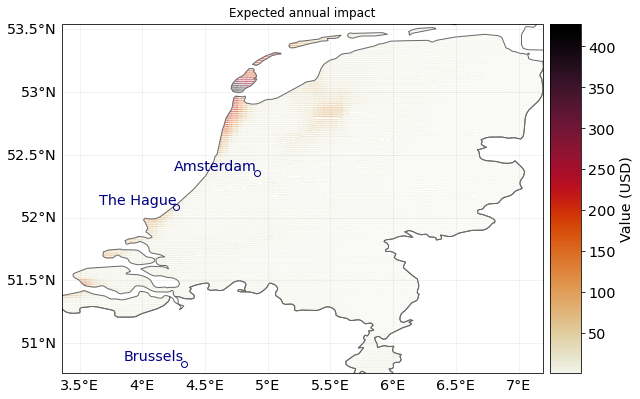

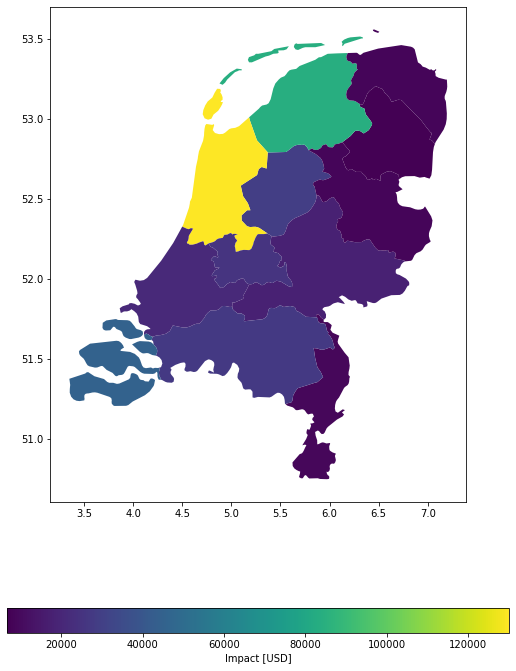

In [25]:
# Plot point-impacts and aggregated impacts
imp_pnt.plot_hexbin_eai_exposure()
u_lp.plot_eai_exp_geom(imp_geom);

**Aggregated impact, in detail**

In [26]:
# aggregate impact matrix
mat_agg = u_lp._aggregate_impact_mat(imp_pnt, exp_pnt3.gdf, agg_met=u_lp.AggMethod.SUM)

eai_exp = u_lp.eai_exp_from_mat(imp_mat=mat_agg, freq=imp_pnt.frequency)
at_event = u_lp.at_event_from_mat(imp_mat=mat_agg)
aai_agg = u_lp.aai_agg_from_at_event(at_event=at_event, freq=imp_pnt.frequency)

In [27]:
eai_exp

array([  6753.45186608,  28953.21638482,  84171.28903387,  18014.15630989,
         8561.18507994,   8986.13653385,  27446.46387061, 130145.29903078,
         8362.17243334,  20822.87844894,  25495.46296087,  45121.14833362])

In [28]:
at_event

array([4321211.03400214,  219950.4291506 ])

In [29]:
aai_agg

412832.8602866131

### Lines

Lines are common geographical representation of transport infrastructure like streets, train tracks or powerlines etc. Here we will play it through for the case of winter storm Lothar's impact on the Dutch Railway System:

#### Loading Data

Note: Hazard and impact functions data have been loaded above.

In [30]:
def gdf_lines():
    gdf_lines = gpd.read_file(Path(DEMO_DIR, "nl_rails.gpkg"))
    gdf_lines = gdf_lines.to_crs(epsg=4326)
    return gdf_lines

In [31]:
exp_nl_lines = Exposures(gdf_lines())
exp_nl_lines.gdf["impf_WS"] = 1
exp_nl_lines.gdf["value"] = 1
exp_nl_lines.gdf.head()

,distance,geometry,impf_WS,value
0,9414.978692,"LINESTRING (6.08850 50.87940, 6.08960 50.87850...",1,1
1,10397.965112,"LINESTRING (6.17673 51.35530, 6.17577 51.35410...",1,1
2,26350.219724,"LINESTRING (5.68096 51.25040, 5.68422 51.25020...",1,1
3,40665.249638,"LINESTRING (5.68096 51.25040, 5.67711 51.25030...",1,1
4,8297.689753,"LINESTRING (5.70374 50.85490, 5.70531 50.84990...",1,1


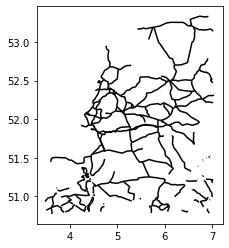

In [32]:
exp_nl_lines.gdf.plot("value", cmap="inferno");

#### Calculating line impacts - all in one

**Example 1**: Disaggregate values evenly among road segments; split in points with 0.005 degree distances.

In [33]:
imp_deg = u_lp.calc_geom_impact(
    exp=exp_nl_lines,
    impf_set=impf_set,
    haz=storms,
    res=0.005,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
    agg_met=u_lp.AggMethod.SUM,
)

/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:931: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  line_lengths = gdf_lines.length


2022-06-24 13:16:59,608 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-06-24 13:16:59,787 - climada.entity.exposures.base - INFO - Matching 10175 exposures with 9944 centroids.
2022-06-24 13:16:59,789 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:16:59,805 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-06-24 13:16:59,806 - climada.engine.impact - INFO - Calculating damage for 10175 assets (>0) and 2 events.


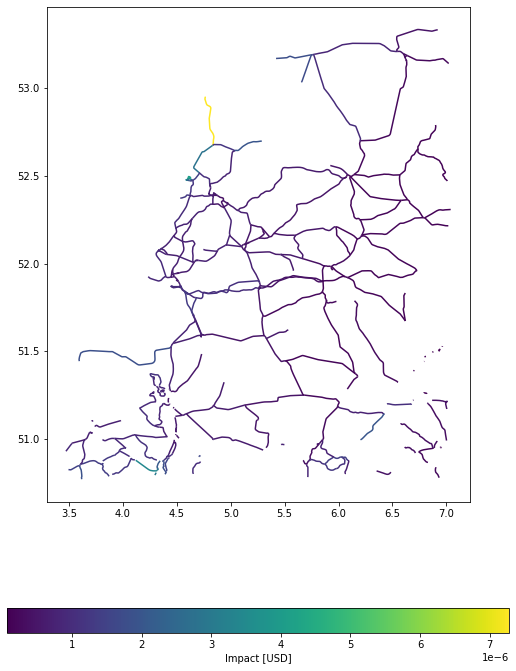

In [34]:
u_lp.plot_eai_exp_geom(imp_deg);

**Example 2**: Disaggregate values evenly among road segments; split in points with 500 m distances.

In [35]:
imp_m = u_lp.calc_geom_impact(
    exp=exp_nl_lines,
    impf_set=impf_set,
    haz=storms,
    res=500,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
    agg_met=u_lp.AggMethod.SUM,
)

2022-06-24 13:17:00,670 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-06-24 13:17:00,827 - climada.entity.exposures.base - INFO - Matching 8399 exposures with 9944 centroids.
2022-06-24 13:17:00,828 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-06-24 13:17:00,843 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-06-24 13:17:00,845 - climada.engine.impact - INFO - Calculating damage for 8399 assets (>0) and 2 events.


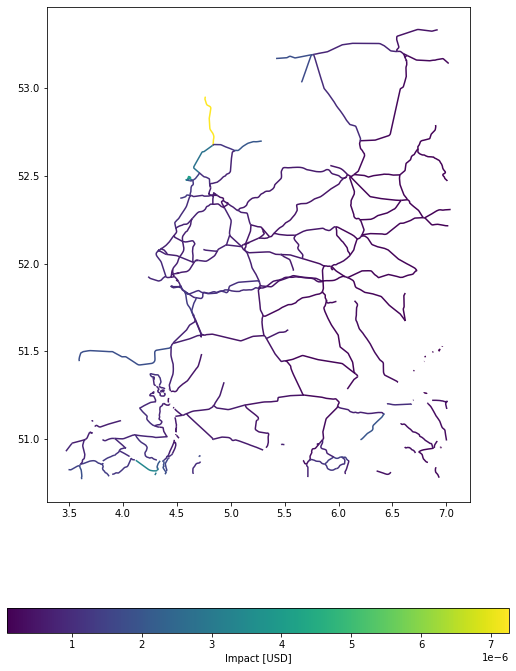

In [36]:
u_lp.plot_eai_exp_geom(imp_m);

In [37]:
import numpy as np

diff = np.max((imp_deg.eai_exp - imp_m.eai_exp) / imp_deg.eai_exp)
print(
    f"The largest relative different between degrees and meters impact in this example is {diff}"
)

The largest relative different between degrees and meters impact in this example is 0.09803913811822067


#### Calculating line impacts - step by step

**Step 1:** As in the polygon example above, there are several methods to disaggregate line exposures into point exposures, of which several are shown here:

In [38]:
# 0.1° distance between points, average value disaggregation
exp_pnt = u_lp.exp_geom_to_pnt(
    exp_nl_lines,
    res=0.1,
    to_meters=False,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
)
exp_pnt.gdf.head()

2022-06-24 13:17:01,409 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/Documents/Climada/climada_python/climada/util/lines_polys_handler.py:931: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  line_lengths = gdf_lines.length


distance                                      geometry_orig  impf_WS  \
0 0   9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1   9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
1 0  10397.965112  LINESTRING (6.17673 51.35530, 6.17577 51.35410...        1   
  1  10397.965112  LINESTRING (6.17673 51.35530, 6.17577 51.35410...        1   
  2  10397.965112  LINESTRING (6.17673 51.35530, 6.17577 51.35410...        1   

        value                  geometry   latitude  longitude  
0 0  0.500000  POINT (6.08850 50.87940)  50.879400   6.088500  
  1  0.500000  POINT (6.06079 50.80030)  50.800300   6.060790  
1 0  0.333333  POINT (6.17673 51.35530)  51.355300   6.176730  
  1  0.333333  POINT (6.12632 51.32440)  51.324399   6.126323  
  2  0.333333  POINT (6.08167 51.28460)  51.284600   6.081670

In [39]:
# 1000m distance between points, no value disaggregation
exp_pnt2 = u_lp.exp_geom_to_pnt(
    exp_nl_lines,
    res=1000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=None,
)
exp_pnt2.gdf.head()

2022-06-24 13:17:01,876 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


distance                                      geometry_orig  impf_WS  \
0 0  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  2  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  3  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  4  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   

     value                  geometry   latitude  longitude  
0 0      1  POINT (6.08850 50.87940)  50.879400   6.088500  
  1      1  POINT (6.09416 50.87275)  50.872755   6.094165  
  2      1  POINT (6.09161 50.86410)  50.864105   6.091608  
  3      1  POINT (6.08744 50.85590)  50.855902   6.087435  
  4      1  POINT (6.08326 50.84770)  50.847699   6.083263

In [40]:
# 1000m distance between points, equal value disaggregation
exp_pnt3 = u_lp.exp_geom_to_pnt(
    exp_nl_lines,
    res=1000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.DIV,
    disagg_val=None,
)
exp_pnt3.gdf.head()

2022-06-24 13:17:02,436 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


distance                                      geometry_orig  impf_WS  \
0 0  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  2  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  3  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  4  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   

        value                  geometry   latitude  longitude  
0 0  0.090909  POINT (6.08850 50.87940)  50.879400   6.088500  
  1  0.090909  POINT (6.09416 50.87275)  50.872755   6.094165  
  2  0.090909  POINT (6.09161 50.86410)  50.864105   6.091608  
  3  0.090909  POINT (6.08744 50.85590)  50.855902   6.087435  
  4  0.090909  POINT (6.08326 50.84770)  50.847699   6.083263

In [41]:
# 1000m distance between points, disaggregation of value according to representative distance
exp_pnt4 = u_lp.exp_geom_to_pnt(
    exp_nl_lines,
    res=1000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=1000,
)
exp_pnt4.gdf.head()

2022-06-24 13:17:03,116 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


distance                                      geometry_orig  impf_WS  \
0 0  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  2  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  3  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  4  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   

     value                  geometry   latitude  longitude  
0 0   1000  POINT (6.08850 50.87940)  50.879400   6.088500  
  1   1000  POINT (6.09416 50.87275)  50.872755   6.094165  
  2   1000  POINT (6.09161 50.86410)  50.864105   6.091608  
  3   1000  POINT (6.08744 50.85590)  50.855902   6.087435  
  4   1000  POINT (6.08326 50.84770)  50.847699   6.083263

**Step 2 & 3:** The procedure is analogous to the example provided above for polygons.